In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"         # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1"    # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1"         # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1"     # export NUMEXPR_NUM_THREADS=6

In [3]:
import time
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_theme(style='whitegrid')

## Baselines

In [23]:
from scipy.linalg import get_blas_funcs

def blasmul(n, testing_duration=1):
    a = np.random.rand(n, n).astype('float32')
    b = np.random.rand(n, n).astype('float32')
    start = time.time()
    cnt = 0
    while time.time() - start < testing_duration:
        gemm = get_blas_funcs("gemm", [a, b])
        c = gemm(1, a, b)
        print(c[0], np.dot(a, b)[0])
        #print(np.all(c == np.dot(a, b)))
        cnt += 1
    duration = (time.time() - start) / cnt
    print(f'[{n}] {duration:6f} x {cnt}')
    return duration

blasmul(1024, 3)

[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369 249.78099 261.10065 ... 250.86981 254.89775 253.85387]
[246.0337  249.78099 261.10062 ... 250.86981 254.89777 253.85388] [246.03369

0.27362548221241345

In [16]:
import torch

torch.set_num_threads(1)

def torchmul(n, testing_duration=1):
    a = torch.rand(n, n)
    b = torch.rand(n, n)
    start = time.time()
    cnt = 0
    while time.time() - start < testing_duration:
        c = torch.mm(a, b)
        cnt += 1
    duration = (time.time() - start) / cnt
    print(f'[{n}] {duration:6f} x {cnt}')
    return duration

torchmul(1024, 3)

[1024] 0.000002 x 1721918


1.7422450427032694e-06

## Benchmarking

In [12]:
def matmul(n, testing_duration=1):
    a = np.random.rand(n, n).astype('float32')
    b = np.random.rand(n, n).astype('float32')
    start = time.time()
    cnt = 0
    while time.time() - start < testing_duration:
        c = np.dot(a, b)
        cnt += 1
    duration = (time.time() - start) / cnt
    print(f'[{n}] {duration:6f} x {cnt}')
    return duration

matmul(1920, 3)

[1920] 0.260431 x 12


0.2604309717814128

In [15]:
def run(binary, n, duration):
    print(f"running with n={n}... ", end="")
    result = !./$binary $n $duration
    print(result[0])
    return float(result[0].split()[0])

def benchmark(source, ns, duration=1, cc='g++'):
    binary = source.split('.')[0] + '.benchmark'
    print(f"compiling {source}")
    !$cc -std=c++17 -O3 -ffast-math -funroll-loops -march=native -Wall benchmark.cc $source -o $binary
    return [run(binary, n, duration) for n in ns]

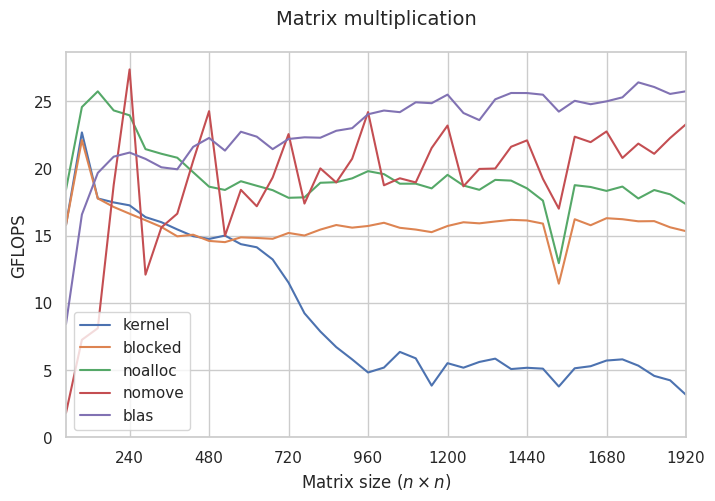

In [212]:
def gflops(l):
    return [n**3 / t / 10 ** 9 for t, n in zip(l, ns)]


def plot(lines, path=None):
    for name, desc in lines:
        plt.plot(ns, gflops(results[name]), label=desc)

    #plt.xscale('log', base=2)
    plt.xticks([48 * k for k in range(5, 41, 5)])
    plt.xlabel('Matrix size ($n \\times n$)')

    plt.ylabel('GFLOPS')
    plt.ylim(bottom=0)

    plt.title("Matrix multiplication", fontsize=14, pad=20)

    if len(lines) >= 2:
        plt.legend(loc='best')

    plt.margins(0)

    fig = plt.gcf()
    fig.set_size_inches(8, 5)
        
    if path:
        fig.savefig(path)
    
    plt.show()

"""
results = {
    'baseline': baseline_smallpages,
    'hugepages': baseline,
    'transposed': transposed,
    'autovec': autovec,
    'vectorized': vectorized,
    'kernel': kernel,
    'blocked': blocked,
    'noalloc': noalloc,
    'nomove': nomove,
    'blas': blas
}
"""

plot([
    #('baseline', 'baseline', None),
    #('hugepages', 'hugepages', None),
    #('transposed', 'transposed', None),
    
    #('autovec', 'auto-vectorized', None),
    #('vectorized', 'manually vectorized', None),
    
    ('kernel', 'kernel'),
    ('blocked', 'blocked'),
    ('noalloc', 'noalloc'),
    ('nomove', 'nomove'),
    ('blas', 'blas')
])

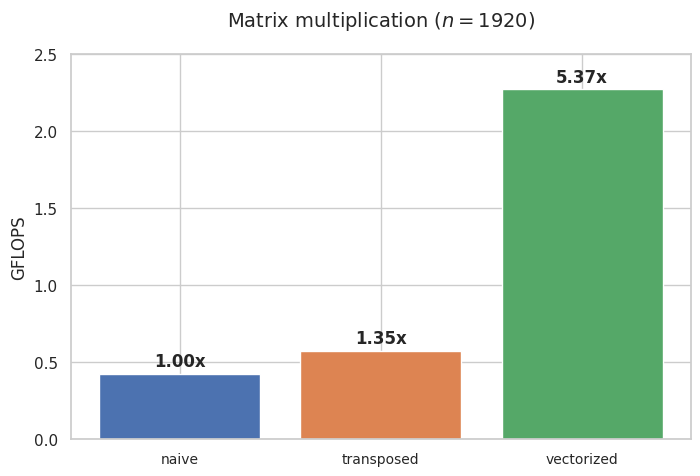

In [256]:
def barplot(bars, path=None):
    plt.title("Matrix multiplication ($n=1920$)", fontsize=14, pad=20)
    plt.ylabel("GFLOPS")

    plt.tick_params(axis='x', labelsize=10)

    baseline = gflops(results['hugepages'])[-1]

    for i, (name, desc) in enumerate(bars):
        x = gflops(results[name])[-1]
        bar = plt.bar(desc, x)
        #bar.set_label('kek')
        #r = bar.get_children()[0]
        txt = plt.bar_label(bar, [f'{x/baseline:.2f}x'], padding=2.5)
        txt[0].set_fontweight(600)
        #plt.text(i - 0.1, x + 0.05, f'{x/baseline:.2f}x')

    fig = plt.gcf()
    fig.set_size_inches(8, 5)
    if path:
        fig.savefig(path)

    plt.show()

plt.ylim(top=2.5)

barplot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
])

## Plots

In [147]:
benchmark('v0.cc', [1920+23])

compiling v0.cc
running with n=1943... 18.492895 x 1


[18.492895]

In [156]:
benchmark('v1.cc', [1920])

compiling v1.cc
running with n=1920... 11.466662 x 1


[11.466662]

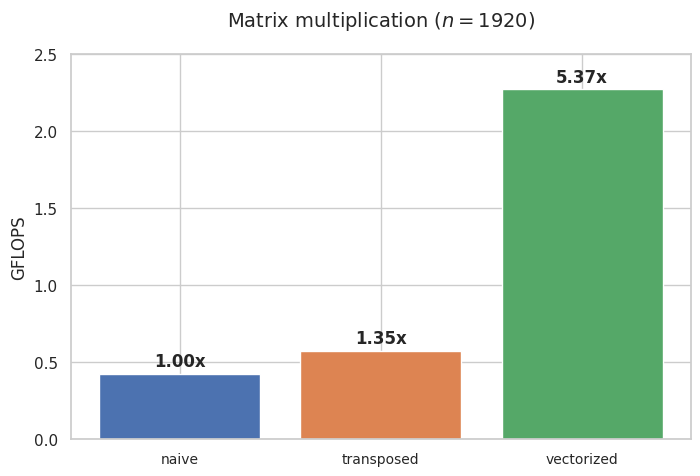

In [258]:
plt.ylim(top=2.5)

barplot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
], 'mm-vectorized-barplot.svg')

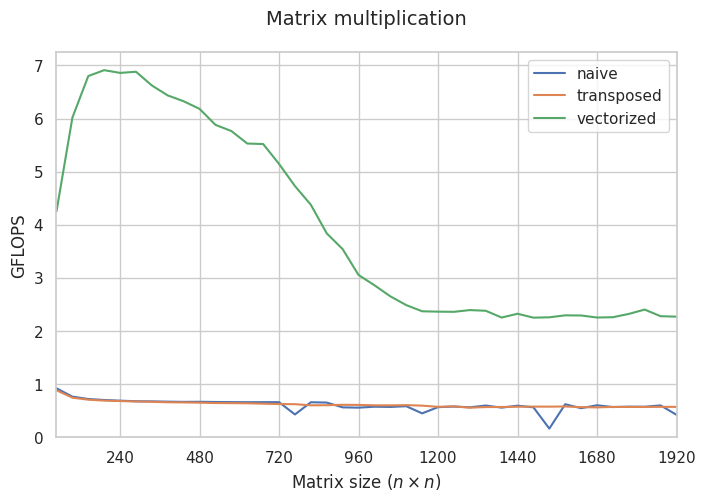

In [259]:
plot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
], 'mm-vectorized-plot.svg')

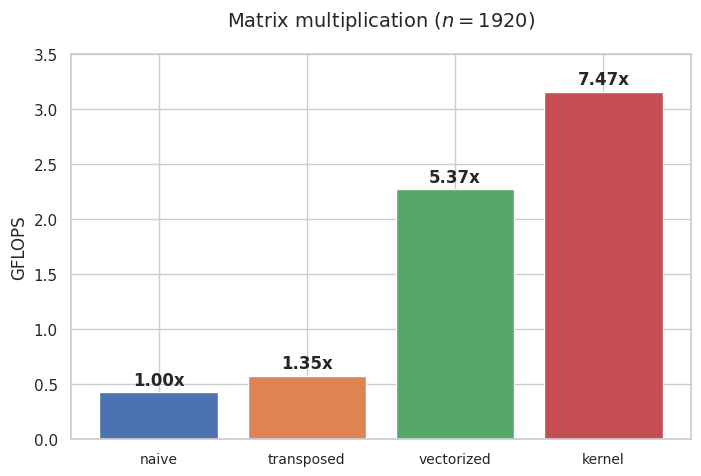

In [261]:
plt.ylim(top=3.5)

barplot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
    ('kernel', 'kernel'),
], 'mm-kernel-barplot.svg')

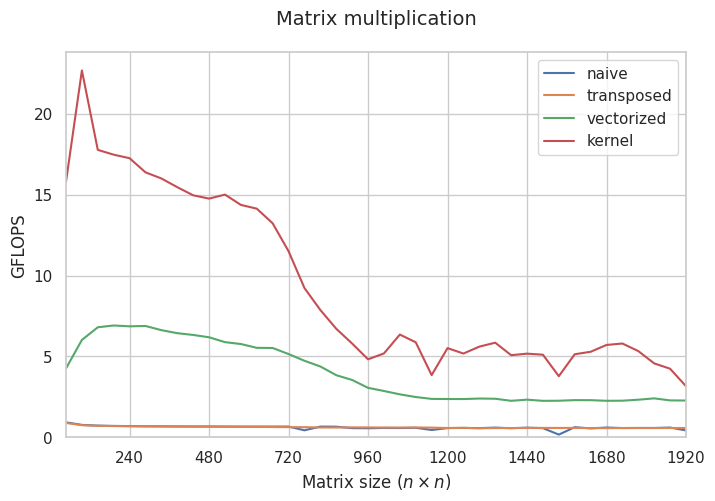

In [262]:
plot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
    ('kernel', 'kernel'),
], 'mm-kernel-plot.svg')

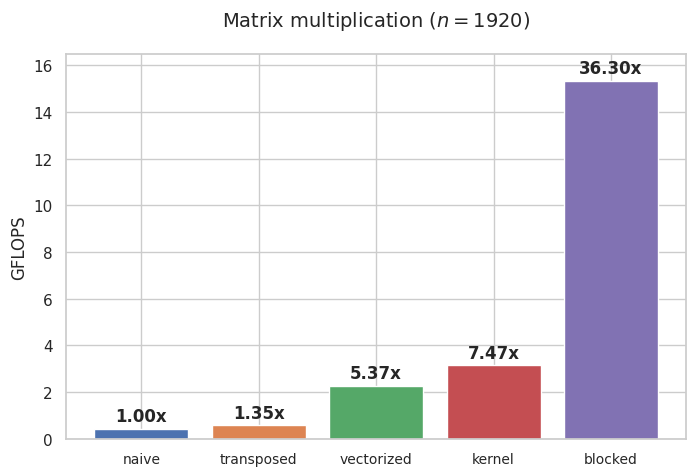

In [264]:
plt.ylim(top=16.5)

barplot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
    ('kernel', 'kernel'),
    ('blocked', 'blocked'),
], 'mm-blocked-barplot.svg')

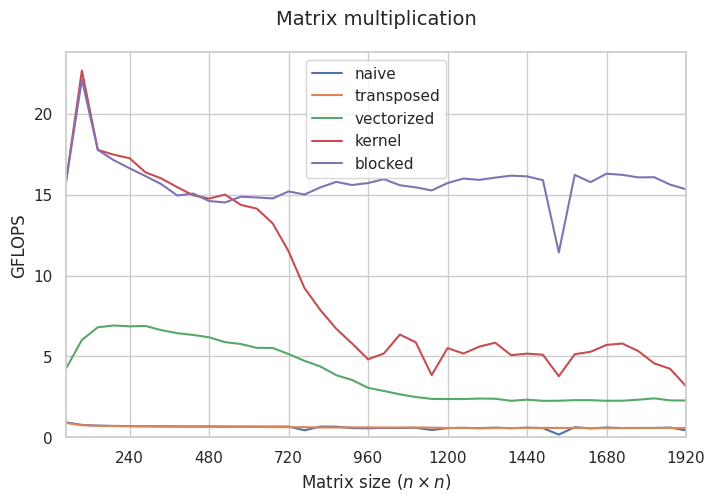

In [265]:
plot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
    ('kernel', 'kernel'),
    ('blocked', 'blocked'),
], 'mm-blocked-plot.svg')

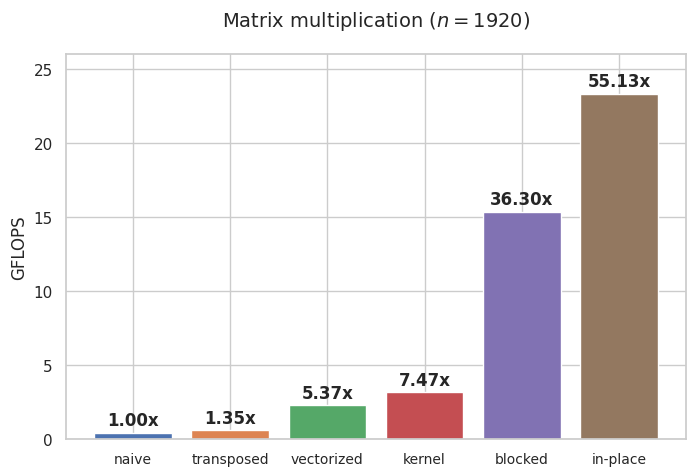

In [269]:
plt.ylim(top=26)

barplot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
    ('kernel', 'kernel'),
    ('blocked', 'blocked'),
    ('nomove', 'in-place'),
], 'mm-noalloc.svg')

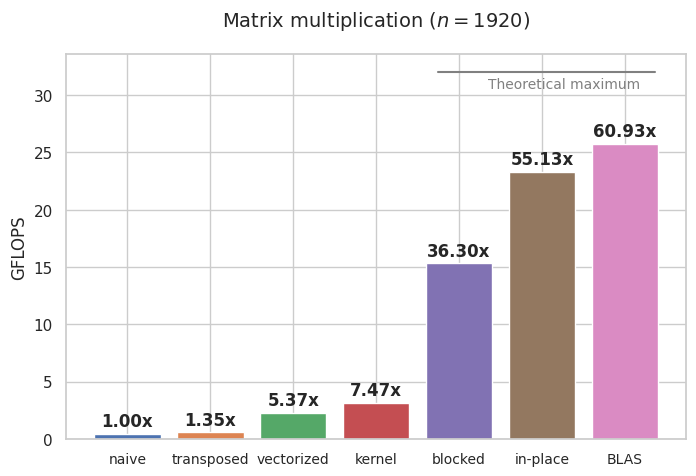

In [270]:
plt.axhline(y=32, color='grey', linestyle='-', xmin=0.6, xmax=0.95)
plt.text(4.35, 30.65, "Theoretical maximum", size=10, color='grey')

barplot([
    ('hugepages', 'naive'),
    ('transposed', 'transposed'),
    ('autovec', 'vectorized'),
    ('kernel', 'kernel'),
    ('blocked', 'blocked'),
    ('nomove', 'in-place'),
    ('blas', 'BLAS'),
], 'mm-blas.svg')

In [275]:
for x, y, n in zip(results['hugepages'], results['blas'], ns):
    print(x / y, n)

9.140784041009743 48
21.67609008902663 96
27.31953062576938 144
29.777263114445233 192
30.754916506266078 240
30.564025765539785 288
29.729911130477774 336
29.765938302214117 384
32.4510054478229 432
33.36484577799739 480
32.13084013006305 528
34.3793262570399 576
33.89752428863942 624
32.45422340587935 672
33.606512343754744 720
52.05166635149845 768
33.82588529711726 816
34.94473114618039 864
40.87489386622065 912
43.12398998534916 960
42.28280990168887 1008
42.39485212799933 1056
42.65537395337988 1104
55.284789038893365 1152
44.988974989128664 1200
41.77712666917743 1248
41.86654513470894 1296
42.1156105799153 1344
45.96332552652664 1392
43.10076003852072 1440
45.21578002269804 1488
148.5518100257598 1536
40.25317063103696 1584
45.30577700379325 1632
41.491461954371424 1680
44.51287523990923 1728
45.85974944465439 1776
45.36023496064805 1824
42.614279995537075 1872
60.931330522270976 1920


In [279]:
benchmark('v0.cc', [1024])
benchmark('v0.cc', [1025])

compiling v0.cc
running with n=1024... 11.927826 x 1
compiling v0.cc
running with n=1025... 3.483147 x 1


[3.483147]

In [277]:
benchmark('v0.cc', [512])
matmul(480)

compiling v0.cc
running with n=512... 0.546497 x 2
[480] 0.005045 x 199


0.00504465198996079

In [171]:
# GHz * throughput * elements
2 * 2 * 8

32

In [ ]:
benchmark('v0.cc', [1920])

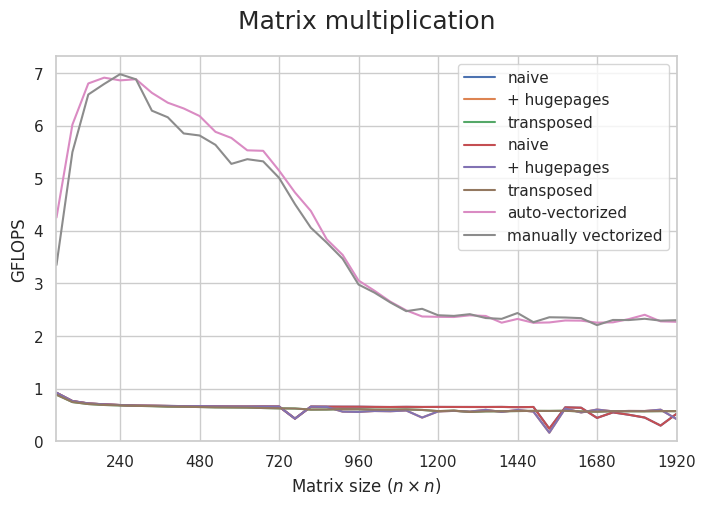

In [155]:
plot([
    ('baseline', 'naive'),
    ('hugepages', '+ hugepages'),
    ('transposed', 'transposed'),
    ('autovec', 'auto-vectorized'),
    ('vectorized', 'manually vectorized'),
])

In [ ]:
plot([
    #('baseline', 'baseline', None),
    #('hugepages', 'hugepages', None),
    #('transposed', 'transposed', None),
    
    #('autovec', 'auto-vectorized', None),
    #('vectorized', 'manually vectorized', None),
    
    ('kernel', 'kernel'),
    ('blocked', 'blocked'),
    ('noalloc', 'noalloc'),
    ('nomove', 'nomove'),
    ('blas', 'blas')
])

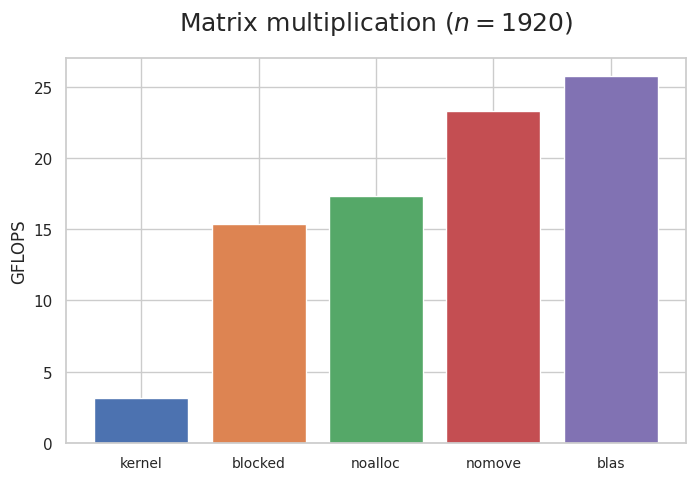

In [131]:
barplot([
    #('baseline', 'baseline', None),
    #('hugepages', 'hugepages', None),
    #('transposed', 'transposed', None),
    
    #('autovec', 'auto-vectorized', None),
    #('vectorized', 'manually vectorized', None),
    
    ('kernel', 'kernel'),
    ('blocked', 'blocked'),
    ('noalloc', 'noalloc'),
    ('nomove', 'nomove'),
    ('blas', 'blas')
])

- Baseline
- Baseline (hugepages)
- Transposed
- Transposed + autovec
- Vectorized
- Kernel
- Blocking
- No allocation
- No extra memory

In [78]:
ns = [48 * k for k in range(1, 41)]

In [96]:
results = {
    'baseline': baseline_smallpages,
    'hugepages': baseline,
    'transposed': transposed,
    'autovec': autovec,
    'vectorized': vectorized,
    'kernel': kernel,
    'blocked': blocked,
    'noalloc': noalloc,
    'nomove': nomove,
    'blas': blas
}

In [99]:
import pickle

with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)

In [94]:
transposed = benchmark('v1.cc', ns, 2)
autovec = benchmark('v1r.cc', ns, 2)
vectorized = benchmark('v3.cc', ns, 2)
kernel = benchmark('v4.cc', ns, 2)
blocked = benchmark('v5.cc', ns, 2)
noalloc = benchmark('v5-noalloc.cc', ns, 2)
nomove = benchmark('v5-unrolled.cc', ns, 2)
blas = [matmul(n, 2) for n in ns]

compiling v1.cc
running with n=48... 0.000125 x 16031
running with n=96... 0.001187 x 1686
running with n=144... 0.004221 x 474
running with n=192... 0.010261 x 195
running with n=240... 0.020280 x 99
running with n=288... 0.035500 x 57
running with n=336... 0.056817 x 36
running with n=384... 0.086008 x 24
running with n=432... 0.122931 x 17
running with n=480... 0.169927 x 12
running with n=528... 0.228455 x 9
running with n=576... 0.297574 x 7
running with n=624... 0.379790 x 6
running with n=672... 0.480279 x 5
running with n=720... 0.596700 x 4
running with n=768... 0.727775 x 3
running with n=816... 0.903267 x 3
running with n=864... 1.069167 x 2
running with n=912... 1.241344 x 2
running with n=960... 1.452687 x 2
running with n=1008... 1.704365 x 2
running with n=1056... 1.961259 x 2
running with n=1104... 2.224397 x 1
running with n=1152... 2.568066 x 1
running with n=1200... 3.016538 x 1
running with n=1248... 3.341447 x 1
running with n=1296... 3.909846 x 1
running with n=13

In [80]:
baseline = benchmark('v0.cc', ns, 2)

compiling v0.cc
running with n=48... 0.000120 x 16725
running with n=96... 0.001157 x 1729
running with n=144... 0.004147 x 483
running with n=192... 0.010093 x 199
running with n=240... 0.020067 x 100
running with n=288... 0.035242 x 57
running with n=336... 0.056132 x 36
running with n=384... 0.084514 x 24
running with n=432... 0.121058 x 17
running with n=480... 0.165648 x 13
running with n=528... 0.221696 x 10
running with n=576... 0.288961 x 7
running with n=624... 0.368178 x 6
running with n=672... 0.459323 x 5
running with n=720... 0.565099 x 4
running with n=768... 1.056301 x 2
running with n=816... 0.824476 x 3
running with n=864... 0.988162 x 3
running with n=912... 1.347958 x 2
running with n=960... 1.587283 x 2
running with n=1008... 1.781037 x 2
running with n=1056... 2.063520 x 1
running with n=1104... 2.302449 x 1
running with n=1152... 3.399834 x 1
running with n=1200... 3.048750 x 1
running with n=1248... 3.365168 x 1
running with n=1296... 3.861285 x 1
running with n=

In [83]:
baseline_smallpages = benchmark('v0.cc', ns, 2)

compiling v0.cc
running with n=48... 0.000120 x 16701
running with n=96... 0.001159 x 1726
running with n=144... 0.004160 x 481
running with n=192... 0.010084 x 199
running with n=240... 0.020097 x 100
running with n=288... 0.035209 x 57
running with n=336... 0.056238 x 36
running with n=384... 0.084273 x 24
running with n=432... 0.120750 x 17
running with n=480... 0.165905 x 13
running with n=528... 0.222129 x 10
running with n=576... 0.289733 x 7
running with n=624... 0.368754 x 6
running with n=672... 0.459271 x 5
running with n=720... 0.566272 x 4
running with n=768... 1.052115 x 2
running with n=816... 0.827514 x 3
running with n=864... 0.980492 x 3
running with n=912... 1.155117 x 2
running with n=960... 1.347685 x 2
running with n=1008... 1.568596 x 2
running with n=1056... 1.808830 x 2
running with n=1104... 2.057809 x 1
running with n=1152... 2.346343 x 1
running with n=1200... 2.648370 x 1
running with n=1248... 2.981816 x 1
running with n=1296... 3.341483 x 1
running with n=

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


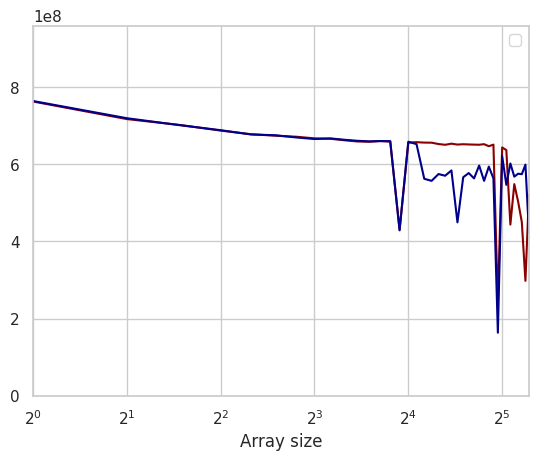

In [93]:
def gflops(l):
    return [n**3 / t for t, n in zip(l, ns)]

plt.plot(gflops(baseline_smallpages), color='darkred')
plt.plot(gflops(baseline), color='darkblue')

plot()

## Random

In [19]:
benchmark("v0.cc", [128, 256, 1024])

compiling v0.cc
running with n=128... 0.002853 x 351
running with n=256... 0.038188 x 27
running with n=1024... 5.517882 x 1


[0.002853, 0.038188, 5.517882]

In [23]:
benchmark("v0.cc", [128, 256, 1024])

compiling v0.cc
running with n=128... 0.002854 x 351
running with n=256... 0.038235 x 27
running with n=1024... 11.866733 x 1


[0.002854, 0.038235, 11.866733]

In [27]:
benchmark("v1.cc", [128, 256, 1024])

compiling v1.cc
running with n=128... 0.002915 x 344
running with n=256... 0.024806 x 41
running with n=1024... 1.744021 x 1


[0.002915, 0.024806, 1.744021]

In [26]:
benchmark("v1r.cc", [128, 256, 1024])

compiling v1r.cc
running with n=128... 0.000318 x 3142
running with n=256... 0.002460 x 407
running with n=1024... 0.305977 x 4


[0.000318, 0.00246, 0.305977]

In [20]:
benchmark("v2.cc", [128, 256, 1024])

compiling v2.cc
running with n=128... 0.000310 x 3227
running with n=256... 0.002422 x 413
running with n=1024... 0.365861 x 3


[0.00031, 0.002422, 0.365861]

In [21]:
benchmark("v3.cc", [128, 256, 1024])

compiling v3.cc
running with n=128... 0.000325 x 3077
running with n=256... 0.002370 x 422
running with n=1024... 0.316511 x 4


[0.000325, 0.00237, 0.316511]

In [22]:
benchmark("v3.cc", [128, 256, 1024])

compiling v3.cc
running with n=128... 0.000326 x 3067
running with n=256... 0.002356 x 425
running with n=1024... 0.299122 x 4


[0.000326, 0.002356, 0.299122]

In [29]:
benchmark("v4.cc", [128, 256, 1024])

compiling v4.cc
running with n=128... 0.000117 x 8541
running with n=256... 0.000991 x 1010
running with n=1024... 0.208545 x 5


[0.000117, 0.000991, 0.208545]

In [34]:
benchmark("v5.cc", [128, 256, 1024])

compiling v5.cc
running with n=128... 0.000120 x 8360
running with n=256... 0.001023 x 978
running with n=1024... 0.090723 x 12


[0.00012, 0.001023, 0.090723]

In [33]:
benchmark("v5.cc", [128, 256, 1024], cc='clang++')

compiling v5.cc
v5.cc:21:24: warning: suggest braces around initialization of subobject [-Wmissing-braces]
    vector t[6][2] = { _mm256_setzero_ps() };
                       ^~~~~~~~~~~~~~~~~~~
                       {                  }
v5.cc:102:11: warning: unused variable 'L1' [-Wunused-const-variable]
const int L1 = (1<<15) / 4; // L1 cache is 32K
          ^
v5.cc:103:11: warning: unused variable 'L2' [-Wunused-const-variable]
const int L2 = (1<<19) / 4; // L2 cache is 512K
          ^
v5.cc:104:11: warning: unused variable 'L3' [-Wunused-const-variable]
const int L3 = (1<<23) / 4; // L3 cache is 8M
          ^
4 warnings generated.
running with n=128... 0.000126 x 7910
running with n=256... 0.001105 x 905
running with n=1024... 0.093522 x 11


[0.000126, 0.001105, 0.093522]

In [37]:
benchmark("v5.cc", [48 * 10, 48 * 20, 48 * 40])

compiling v5.cc
running with n=480... 0.006509 x 154
running with n=960... 0.047989 x 21
running with n=1920... 0.382294 x 3


[0.006509, 0.047989, 0.382294]

In [47]:
benchmark("v5-noalloc.cc", [48 * 10, 48 * 20, 48 * 40], duration=5)

compiling v5-noalloc.cc
running with n=480... 0.005006 x 999
running with n=960... 0.039891 x 126
running with n=1920... 0.363641 x 14


[0.005006, 0.039891, 0.363641]

In [50]:
benchmark("v5-noalloc.cc", [48 * 10, 48 * 20, 48 * 40], duration=5)

compiling v5-noalloc.cc
running with n=480... 0.004760 x 1051
running with n=960... 0.039151 x 128
running with n=1920... 0.344712 x 15


[0.00476, 0.039151, 0.344712]

In [66]:
benchmark("v5-noalloc.cc", [48 * 10, 48 * 20, 48 * 40], duration=5)

compiling v5-noalloc.cc
running with n=480... 0.005356 x 934
running with n=960... 0.043759 x 115
running with n=1920... 0.390885 x 13


[0.005356, 0.043759, 0.390885]

In [56]:
benchmark("v5-noalloc.cc", [48 * 10, 48 * 20, 48 * 40], duration=5)

compiling v5-noalloc.cc
running with n=480... 0.004355 x 1149
running with n=960... 0.034801 x 144
running with n=1920... 0.290641 x 18


[0.004355, 0.034801, 0.290641]

In [82]:
matmul(48*20, 5)

[960] 0.034838 x 144


0.034837812185287476

In [81]:
benchmark("v5-unrolled.cc", [48 * 20], duration=5)

compiling v5-unrolled.cc
running with n=960... 0.034334 x 146


[0.034334]

In [71]:
benchmark("v5-unrolled.cc", [48 * 10, 48 * 20, 48 * 40], duration=5)

compiling v5-unrolled.cc
running with n=480... 0.008089 x 619
running with n=960... 0.040543 x 124
running with n=1920... 0.276888 x 19


[0.008089, 0.040543, 0.276888]

In [61]:
benchmark("v5-unrolled.cc", [112, 112 * 10, 112 * 15], duration=5)

compiling v5-unrolled.cc
running with n=112... 0.000098 x 50888
running with n=1120... 0.112802 x 45
running with n=1680... 0.388875 x 13


[9.8e-05, 0.112802, 0.388875]

In [64]:
benchmark("v5-noalloc.cc", [112, 112 * 10, 112 * 15], duration=5)

compiling v5-noalloc.cc
running with n=112... 0.000057 x 87781
running with n=1120... 0.069149 x 73
running with n=1680... 0.247275 x 21


[5.7e-05, 0.069149, 0.247275]

In [62]:
[matmul(n, 5) for n in [112, 112 * 10, 112 * 15]]

[112] 0.000078 x 64134
[1120] 0.056493 x 89
[1680] 0.187275 x 27


[7.796225826008734e-05, 0.05649328499697567, 0.1872749063703749]

In [49]:
[matmul(n, 5) for n in [48 * 10, 48 * 20, 48 * 40]]

[480] 0.004641 x 1078
[960] 0.034655 x 145
[1920] 0.261120 x 20


[0.004640667911805558, 0.03465493629718649, 0.2611196994781494]

In [32]:
benchmark("v6.cc", [128, 256, 1024])

compiling v6.cc
running with n=128... 0.000127 x 7898
running with n=256... 0.001016 x 985
running with n=1024... 0.166681 x 6


[0.000127, 0.001016, 0.166681]

In [17]:
benchmark("v0.cc", [128, 256, 1024], cc='clang++')

compiling v0.cc
running with n=128... 0.004606 x 218
running with n=256... 0.039917 x 26
running with n=1024... 5.551821 x 1


[0.004606, 0.039917, 5.551821]

In [7]:
benchmark("v3.cc", [128, 256, 1024])

compiling v3.cc
v3.cc:17:23: optimized: loop vectorized using 32 byte vectors
running with n=128... 0.000504 x 1986
running with n=256... 0.003988 x 251
running with n=1024... 0.379358 x 3


[0.000504, 0.003988, 0.379358]

In [11]:
[matmul(n) for n in [128, 256, 1024]]

0.000053 x 18959
0.000292 x 3421
0.014097 x 71


[5.2751610252548984e-05, 0.0002923565836407155, 0.014097371571500537]

In [36]:
n = 1000
a = np.random.zeros(n, n).astype('int32')
b = np.random.rand(n, n).astype('int32')
start = time.time()
cnt = 0
while time.time() - start < 5:
    c = np.dot(a, b)
    cnt += 1
duration = (time.time() - start) / cnt
print(f'[{n}] {duration:6f} x {cnt}')

[1000] 3.007641 x 2


In [43]:
np.random.randint()

array([3, 0])

In [37]:
matmul(1000, 5)

[1000] 0.051945 x 97


0.05194487768350188

In [9]:
ns = [48*2, 48*5, 48*20, 2000]
benchmark("v4.cc", ns, 2)
benchmark("v5.cc", ns, 2)
[matmul(n, 2) for n in ns]

compiling v4.cc
running with n=96... 0.000059 x 34140
running with n=240... 0.001107 x 1807
running with n=960... 0.148153 x 14
running with n=2000... 1.617119 x 2
compiling v5.cc
running with n=96... 0.000059 x 33822
running with n=240... 0.001082 x 1849
running with n=960... 0.062717 x 32
running with n=2000... 0.532937 x 4
0.000077 x 26028
0.000901 x 2220
0.047909 x 42
0.409638 x 5


[7.68426616235466e-05,
 0.0009009764001176164,
 0.047909413065229146,
 0.4096375942230225]

In [23]:
#sources = sorted(glob.glob("v*.c*"))
#ns = [256, 256+128, 512, 512+256, 1024, 1024+256, 1024+512, 1024+512+256, 2048]
#ns = [128, 256, 512, 1024]

sources = ['v5.cc', 'v6.cc']
ns = [96 * i for i in range(1, 21)]

results = [benchmark(source, ns, 2) for source in sources]

compiling v5.cc
running with n=96... 0.000056 x 35853
running with n=192... 0.000564 x 3544
running with n=288... 0.001867 x 1072
running with n=384... 0.004346 x 461
running with n=480... 0.008054 x 249
running with n=576... 0.013751 x 146
running with n=672... 0.021356 x 94
running with n=768... 0.032623 x 62
running with n=864... 0.043853 x 46
running with n=960... 0.058874 x 34
running with n=1056... 0.079772 x 26
running with n=1152... 0.104404 x 20
running with n=1248... 0.131193 x 16
running with n=1344... 0.163595 x 13
running with n=1440... 0.195758 x 11
running with n=1536... 0.322031 x 7
running with n=1632... 0.282646 x 8
running with n=1728... 0.347328 x 6
running with n=1824... 0.401635 x 5
running with n=1920... 0.475576 x 5
compiling v6.cc
running with n=96... 0.000074 x 27040
running with n=192... 0.000615 x 3250
running with n=288... 0.001954 x 1024
running with n=384... 0.004365 x 459
running with n=480... 0.008191 x 245
running with n=576... 0.013925 x 144
running w

[96] 0.000074 x 26849
[192] 0.000470 x 4257
[288] 0.001470 x 1361
[384] 0.003285 x 609
[480] 0.006114 x 328
[576] 0.010308 x 195
[672] 0.016464 x 122
[768] 0.023658 x 85
[864] 0.033364 x 60
[960] 0.045965 x 44
[1056] 0.059994 x 34
[1152] 0.077512 x 26
[1248] 0.098478 x 21
[1344] 0.122740 x 17
[1440] 0.148788 x 14
[1536] 0.181200 x 12
[1632] 0.217583 x 10
[1728] 0.256233 x 8
[1824] 0.299285 x 7
[1920] 0.352238 x 6


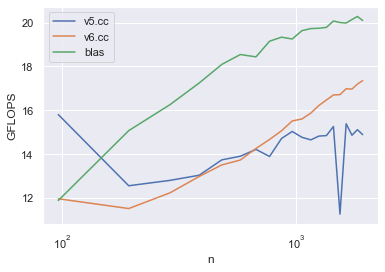

In [25]:
sources.append('blas')
results.append([matmul(n, 2) for n in ns])

for r in results:
    plt.plot(ns, [(n**3) / x / (10**9) for x, n in zip(r, ns)])

plt.xlabel('n')
plt.ylabel('GFLOPS')

plt.xscale('log')
plt.legend(sources)

In [56]:
ghz = 4.1
fma = 2
simd = 8
print(ghz * fma * simd)

65.6


In [ ]:
sources.append('blas')
ns = []

results.append([matmul(n) for n in ns])

for r in results:
    plt.plot(ns, [(n**3) / x / (10**9) for x, n in zip(r, ns)])